# Real estate price prediction with linear regression

In this notebook, We'll work with web-scraped data from www.imot.bg - a website for real estate ads. The data is only for Sofia, Plovdiv and Varna - the three biggest cities in Bulgaria. The notebook first includes exploration and cleaning of the dataset followed by prediction of prices.

## Import libraries

We'll import `pandas` to read the dataset, `numpy` to work with arrays, `matplotlib` and `seaborn` for our visualizations and `sklearn` for our linear regression model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
plt.style.use('ggplot')

## Read the dataset

In [3]:
df = pd.read_excel(r'data/imot_bg_dataset.xlsx', sheet_name='Sheet1')

In [4]:
df.head()

,link,city,district,property_type,price,price_tax_included,area,floor,gas,tec,building_type,year_built,features_list
0,https://www.imot.bg/pcgi/imot.cgi?act=5&adv=1a...,София,Белите брези,1-Стаен,80 000 EUR,Да,37,14-ти от 18,NaN,Да,ЕПК,1985.0,"ЕПК, Асансьор"
1,https://www.imot.bg/pcgi/imot.cgi?act=5&adv=1a...,София,Бояна,1-Стаен,41 990 EUR,Да,31,Партер от 5,NaN,NaN,Тухла,2008.0,"Тухла, Контрол на достъпа, Саниран"
2,https://www.imot.bg/pcgi/imot.cgi?act=5&adv=1a...,София,Витоша,1-Стаен,109 990 EUR,Да,50,2-ри от 4,NaN,NaN,Тухла,2000.0,"Тухла, С паркинг, Обзаведен, Саниран"
3,https://www.imot.bg/pcgi/imot.cgi?act=5&adv=1a...,София,Военна рампа,1-Стаен,69 971 EUR,Да,51,5-ти от 5,Не,Не,Тухла,2025.0,"Тухла, Асансьор"
4,https://www.imot.bg/pcgi/imot.cgi?act=5&adv=1a...,София,Гео Милев,1-Стаен,105 000 EUR,Да,30,9-ти от 9,NaN,Да,Тухла,1990.0,"Тухла, Интернет връзка, Асансьор, Обзаведен, К..."


In [5]:
df.shape

(2932, 13)

We have 2932 ads collected in our data. Each ad has 13 features.

## Data tidying and cleaning

We don't have any duplicates in our data

In [6]:
df.duplicated().unique()

array([False])

We convert the price to 'EUR' if it's in 'лв. '

In [7]:
price = df['price'].str.replace(' ','').str[:-3].astype(float)
currency = df['price'].str.replace(' ','').str[-3:]

df['price'] = np.where(
    currency.str.contains('лв.'),
    price * 0.51,
    price
)

df.rename(columns = {'price':'price_eur'}, inplace = True)

We add the tax to the price if it's listed without the tax. The tax in Bulgaria is 20%.

In [8]:
df['price_eur'] = np.where(
    df['price_tax_included'] == 'Не',
    df['price_eur'] + (df['price_eur'] * 0.20),
    df['price_eur']
).astype(int)

df = df.drop('price_tax_included', axis = 1)

We rename `property_type` to `number_of_rooms`, because this feature indicates only the number of rooms the property has.

In [9]:
df.rename(columns = {'property_type':'number_of_rooms'}, inplace = True)
df['number_of_rooms'] = df.number_of_rooms.str.get(0).astype(int)

We create a new feature `is_built` that shows if the property is built or is still under construction. We consider the properties which build year is unspecified and are not under construction as 1 - built. The properties that are marked as 0 - 'Under construction' and their built year is 2023 are considered as 'Under constructions'. If the built year is after 2023 the property is also considered as 'Under construction'.

In [10]:
df['is_built'] = np.where(
    ((df['features_list'].str.contains('В строеж')) & (df['year_built'] == 2023)) |
    (df['year_built'] > 2023),
    0,
    1
)

We create 2 new features that show if the property has parking or garage.

In [11]:
df['has_parking'] = np.where(df['features_list'].str.contains('С паркинг'),1,0)
df['has_garage'] = np.where(df['features_list'].str.contains('С гараж'),1,0)

We convert `gas` and `tec` to int where 0 - No and 1 - Yes. We also replace the NA values with 0 - No, because these properties weren't included in the advertisement.

In [12]:
df['gas'] = df['gas'].replace(['Не', 'Да'],[0, 1]).astype('Int64')
df['gas'] = df['gas'].fillna(0)

df['tec'] = df['tec'].replace(['Не', 'Да'],[0, 1]).astype('Int64')
df['tec'] = df['tec'].fillna(0)

We remove the `features_list` column, because we got the data we need from it and we don't need it anymore.

In [13]:
df = df.drop('features_list', axis = 1)

We calculate the price per square meter.

In [14]:
df['price_per_square_meter'] = (df['price_eur'] / df['area']).astype(int)

##  Exploratory Data Analysis

In [15]:
df.city.value_counts()

София      992
Варна      985
Пловдив    955
Name: city, dtype: int64

We have a similar count of ads for the 3 cities.

In [16]:
df.number_of_rooms.value_counts()

2    1448
3    1227
1     257
Name: number_of_rooms, dtype: int64

Most of the apartments are with 2 or 3 rooms.

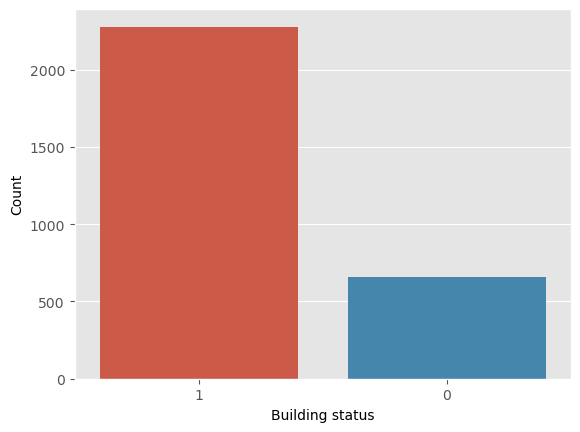

In [17]:
plot = sns.countplot(x = 'is_built', data = df, order = df['is_built'].value_counts().index)
plt.ylabel("Count")
plt.xlabel("Building status")
plt.show()

Most of the properties are built.

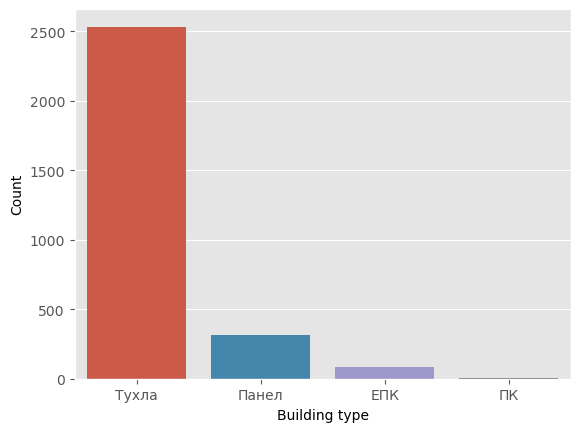

In [18]:
plot = sns.countplot(x = 'building_type', data = df, order = df['building_type'].value_counts().index)
plt.ylabel("Count")
plt.xlabel("Building type")
plt.show()

Almost all of the properties are built by bricks.

In [19]:
df.groupby('city').price_per_square_meter.median().sort_values(ascending=False)

city
София      1783.5
Варна      1271.0
Пловдив    1156.0
Name: price_per_square_meter, dtype: float64

The mean price per $m^2$ in Sofia is significantly bigger than the rest of the cities. This is because Sofia is the capital city of Bulgaria and it's normal to have more expensive properties.

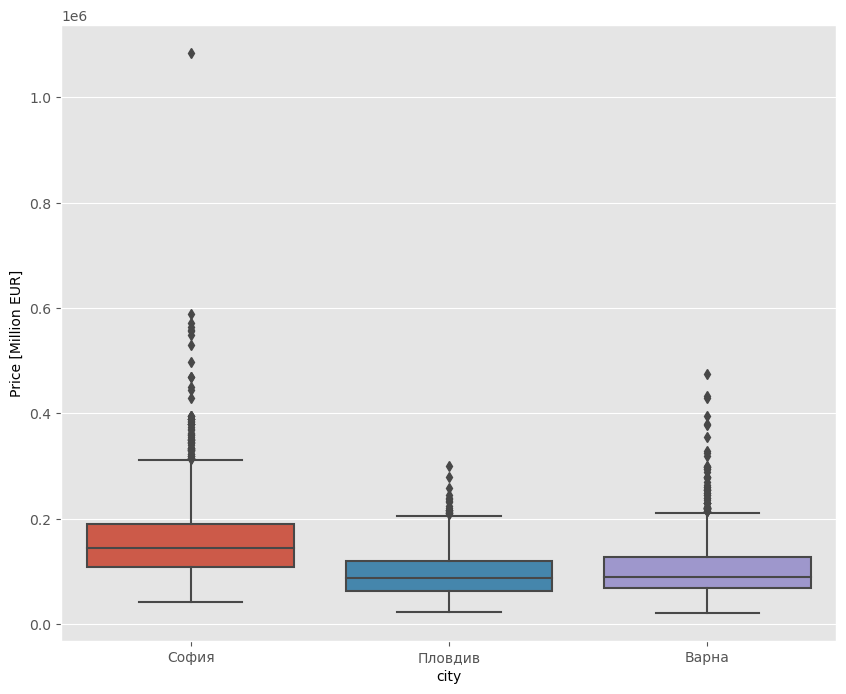

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='city', y='price_eur')
plt.ylabel("Price [Million EUR]")
plt.show()

We have an oultlier with a price of over a million euros in Sofia. We decide to remove it, because it's just one case and it's value is way over the rest of the values. We won't remove the outliers for the other cities, because none of the outliers is way over the rest of the values. We will treat the outliers instead.

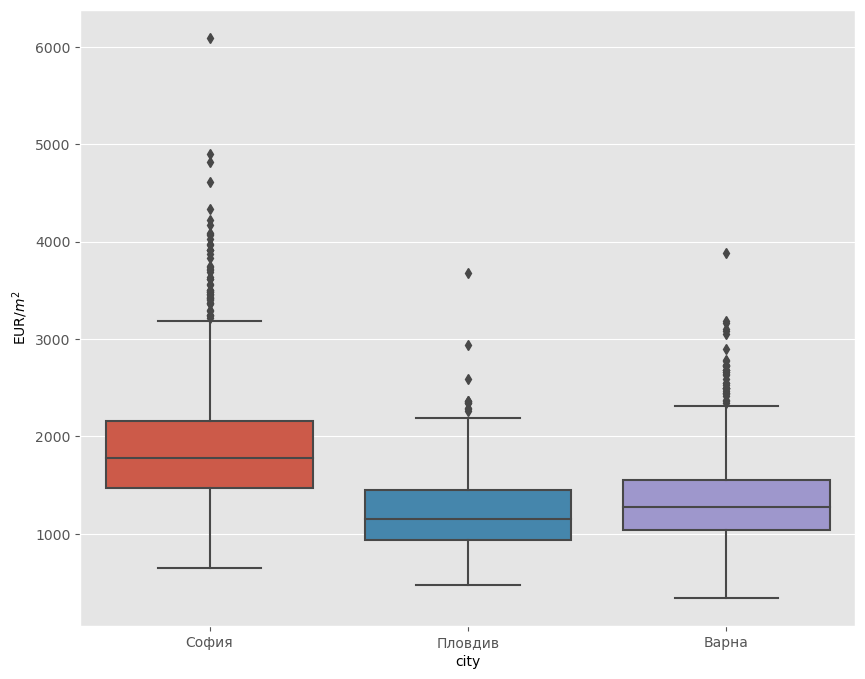

In [21]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='city', y='price_per_square_meter')
plt.ylabel("EUR/$m^2$")
plt.show()

We'll also remove the records where `price_per_square_meter` > 5000 for Sofia, > 3000 for Plovdiv and > 3500 for Varna.

In [22]:
indices_to_remove = df[((df.city == 'София') & ((df.price_per_square_meter > 5000))) |
                      ((df.city == 'Пловдив') & (df.price_per_square_meter > 3000)) |
                      ((df.city == 'Варна') & ((df.price_per_square_meter > 3500)))].index

df = df.drop(indices_to_remove)

The other outliers we have in our data are not due to bad data or human error, but are real data - there are some really expensive apartments in these cities, especially in Sofia. We decide to take care of our outliers, instead of deleting them from the dataset.

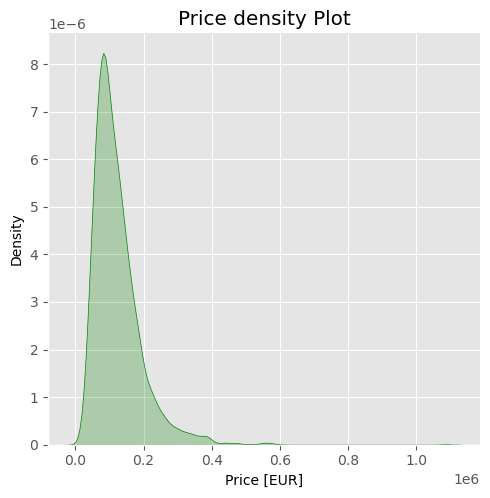

In [23]:
sns.displot(df['price_eur'], kind='kde', fill=True, color='green')
plt.xlabel("Price [EUR]")
plt.ylabel("Density")
plt.title("Price density Plot")
plt.show()

In [24]:
df.price_eur.skew()

2.6182492452555257

We create a density plot for price and see that our data is scewed to the right (positively skewed).

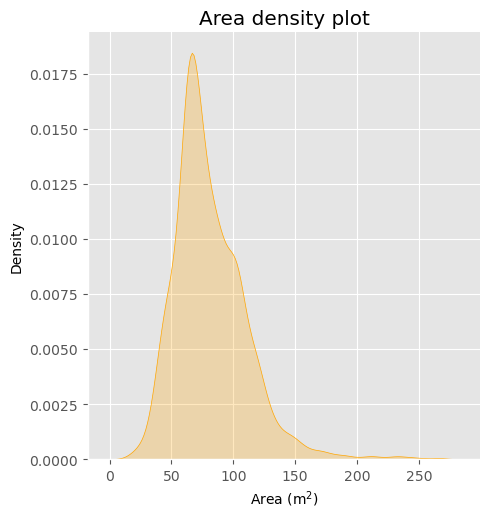

In [25]:
# sns.kdeplot(df['area'], fill=True, color='orange')
sns.displot(df['area'], kind='kde', fill=True, color='orange')
sns.set_palette("pastel")
plt.xlabel("Area (m$^2$)")
plt.ylabel("Density")
plt.title("Area density plot")
plt.show()

In [26]:
df.area.skew()

1.4376339412322339

The data for area is also skewed to the right.

## Data transformations

Since our data is positively skewed (skewed to the right), we can use logarithmic transformations to reduce the skewness - our data will become relatively symmetrical.

In [27]:
df['price_eur_transformed'] = np.log10(df.price_eur)
df['area_transformed'] = np.log10(df.area)

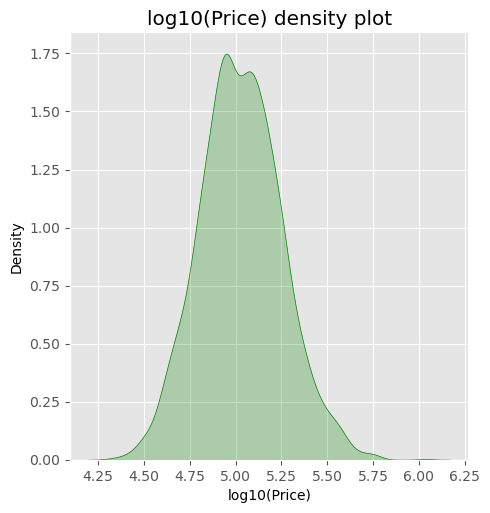

In [28]:
sns.displot(df['price_eur_transformed'], kind='kde', fill=True, color='green')
sns.set_palette("pastel")
plt.xlabel("log10(Price)")
plt.ylabel("Density")
plt.title("log10(Price) density plot")
plt.show()

In [29]:
df['price_eur_transformed'].skew()

0.17811509894494768

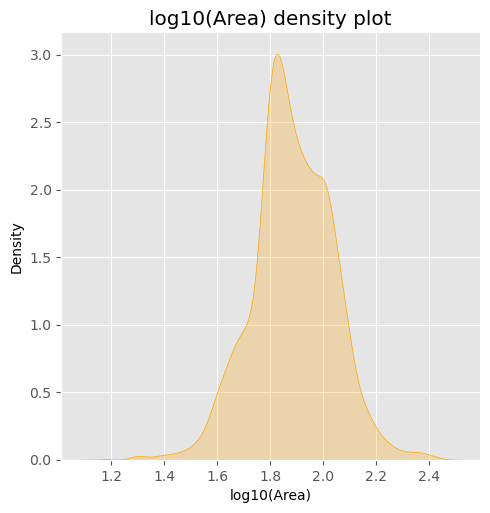

In [43]:
sns.displot(df['area_transformed'], kind='kde', fill=True, color='orange')
plt.xlabel("log10(Area)")
plt.ylabel("Density")
plt.title("log10(Area) density plot")
plt.show()

In [44]:
df['area_transformed'].skew()

-0.09718788522887559

After transforming the columns for price and area, they are now relatively symmetrical. We can now use our transformed data in our linear regression model.

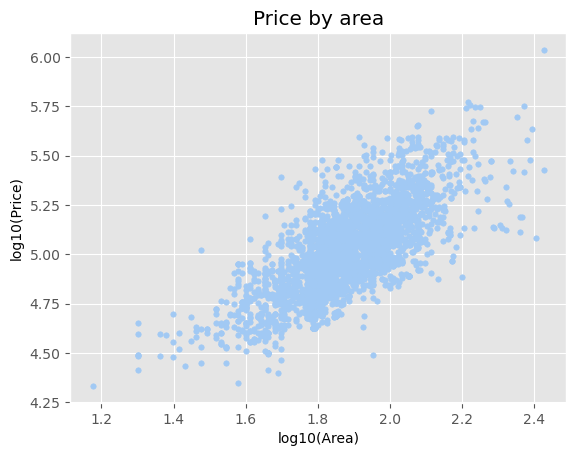

In [32]:
plt.scatter(df['area_transformed'],df['price_eur_transformed'], s = 15)
plt.xlabel('log10(Area)')
plt.ylabel('log10(Price)')
plt.title('Price by area')
plt.show()

From the scatterplot and the table below we can see that price and area are highly correlated.

In [33]:
df[['area_transformed','price_eur_transformed']].corr()

,area_transformed,price_eur_transformed
area_transformed,1.000000,0.731558
price_eur_transformed,0.731558,1.000000


## Prepare the categorical data for linear regression

We create dummy variables for city, because we can't use a categorical variable with more than 2 answers (0 and 1) in our linear regression.

In [34]:
df = pd.get_dummies(df, columns = ['city'])
df.rename(columns = {'city_София':'city_Sofia',
                     'city_Пловдив':'city_Plovdiv',
                     'city_Варна':'city_Varna'}, inplace = True)
df[['city_Sofia','city_Plovdiv','city_Varna']].head()

,city_Sofia,city_Plovdiv,city_Varna
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [35]:
corr = df[['price_eur_transformed', 'area_transformed', 'number_of_rooms', 'is_built', 'has_garage',
           'has_parking', 'gas', 'tec', 'city_Sofia', 'city_Plovdiv', 'city_Varna']].corr()
corr.style.background_gradient(cmap='coolwarm')

,price_eur_transformed,area_transformed,number_of_rooms,is_built,has_garage,has_parking,gas,tec,city_Sofia,city_Plovdiv,city_Varna
price_eur_transformed,1.000000,0.731558,0.614402,0.115121,0.103038,-0.027340,0.245707,0.218442,0.449702,-0.280278,-0.172393
area_transformed,0.731558,1.000000,0.777956,-0.003746,0.105181,0.019663,0.120967,0.007115,0.126866,-0.036072,-0.091297
number_of_rooms,0.614402,0.777956,1.000000,0.055812,0.017295,0.000132,0.028836,0.030649,0.053609,-0.056584,0.002441
is_built,0.115121,-0.003746,0.055812,1.000000,-0.187704,-0.099544,-0.176078,0.018477,-0.139211,0.117737,0.022635
has_garage,0.103038,0.105181,0.017295,-0.187704,1.000000,0.380807,0.156740,0.022707,0.193991,-0.176828,-0.018879
has_parking,-0.027340,0.019663,0.000132,-0.099544,0.380807,1.000000,0.007640,-0.003277,0.009338,-0.124420,0.114096
gas,0.245707,0.120967,0.028836,-0.176078,0.156740,0.007640,1.000000,-0.084346,0.427752,-0.224430,-0.205818
tec,0.218442,0.007115,0.030649,0.018477,0.022707,-0.003277,-0.084346,1.000000,0.483711,-0.230310,-0.256040
city_Sofia,0.449702,0.126866,0.053609,-0.139211,0.193991,0.009338,0.427752,0.483711,1.000000,-0.496993,-0.508625
city_Plovdiv,-0.280278,-0.036072,-0.056584,0.117737,-0.176828,-0.124420,-0.224430,-0.230310,-0.496993,1.000000,-0.494343


In the correlation matrix we see that the features that are most correlated to the price are `area`, `number_of_rooms` and `city_{cityName}`. `area` and `number_of_rooms` are highly correlated and if we include both of them we'll have a collinearity problem. We'll only use `area` in our model, because it has bigger correlation coefficient.

`price` and `s_built` have negligible positive correlation, but the properties that are under construction are generally cheaper than the ones already built, so we decide to include this feature also. 

In [36]:
df.groupby('is_built').price_eur.mean().sort_values(ascending=False)

is_built
1    127142.295515
0    105420.511450
Name: price_eur, dtype: float64

`gas`, `tec`, `has_parking` and `has_garage` also have negligible correlation and we decide to not include them in our model.

In [37]:
x = df[['area_transformed',
        'is_built',
        'city_Sofia',
        'city_Plovdiv', 
        'city_Varna']]

y = df['price_eur_transformed']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.40, random_state = 42)

##  Training and predicting

We create a Linear Regression model to train on the data and use it for future predictions.

In [39]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
prediction = linear_model.predict(X_test)

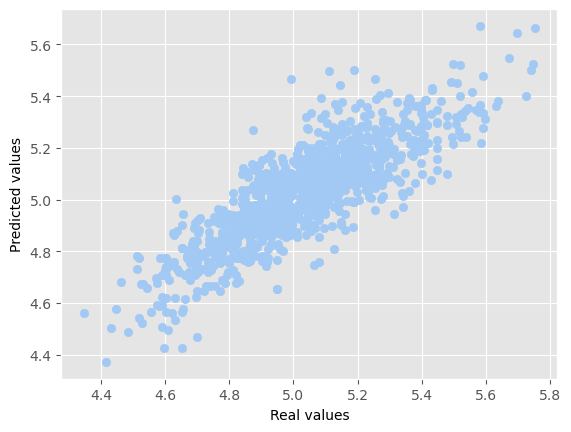

In [40]:
plt.scatter(y_test, prediction)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

In [41]:
r2_score(y_test, prediction)

0.7042288661572316

We evaluate our model using the r$^2$ score. Approximately 70% of the observed variation can be explained by the model’s inputs. 

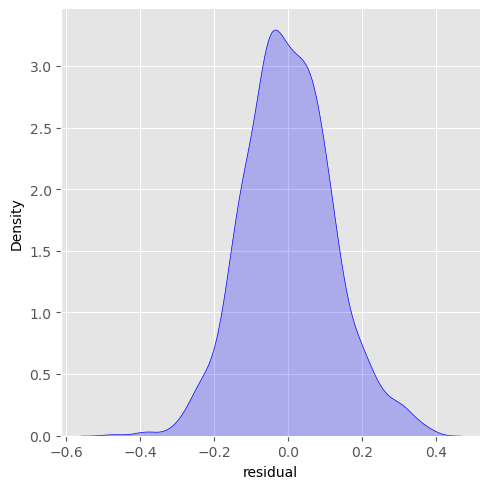

In [45]:
residual = y_test - prediction

sns.displot(residual, kind='kde', fill = True, color = 'blue')
plt.xlabel('residual')
plt.show()

We also plot the residual - the difference between true values and predicted values, and it has bell-shaped distribution, which means that our model is performing good and can predict close to real values.